# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Авто.ру» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

Нужно построить модель для определения стоимости.

## Загрузка данных

In [1]:
# Скачиваем нужные библиотеки
!pip install beautifulsoup4==4.9.3 matplotlib==3.3.4 nltk==3.6.1 numpy==1.20.1 pandas==1.2.4 plotly==5.4.0 psycopg2-binary==2.9.2 regex==2022.3.15 scikit-learn==1.6 scipy==1.8.0 seaborn==0.11.1 sqlalchemy==1.4.15 statsmodels==0.13.2 phik lightgbm category_encoders wordcloud --upgrade pip --upgrade Pillow

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
pip install ydata-profiling

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Подключаем нужные библиотеки
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import TargetEncoder
from wordcloud import WordCloud
import ydata_profiling
%matplotlib inline

In [4]:
# Напишем функцию для считывания данных из csv файла и записывания в датафрейм
def df_read_csv(pth1, pth2):
    if os.path.exists(pth1):
        return pd.read_csv(pth1)
    elif os.path.exists(pth2):
        return pd.read_csv(pth2)
    else:
        print('Что-то пошло не так')

In [5]:
# Считываем данные из csv файла и записываем их в переменную df
df_autos = df_read_csv('/datasets/autos.csv', 'https://code.s3.yandex.net/datasets/autos.csv')

In [6]:
# Создадим функцию, для отображения нужной информации о датафрейме
def df_info(df):
    display(df.head(10))
    display(df.info())
    display(df.describe())

In [7]:
# Отобразим информацию о df_autos
df_info(df_autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


После загрузки необходимых файлов, имеем 1 датафрейм и 16 уникальных столбцов с данными.

В датафрейме `df_autos` мы сохранили данные о технических характеристиках, комплектации и ценах других автомобилей.

**Описание данных:**
1. DateCrawled — дата скачивания анкеты из базы
2. VehicleType — тип автомобильного кузова
3. RegistrationYear — год регистрации автомобиля
4. Gearbox — тип коробки передач
5. Power — мощность (л. с.)
6. Model — модель автомобиля
7. Kilometer — пробег (км)
8. RegistrationMonth — месяц регистрации автомобиля
9. FuelType — тип топлива
10. Brand — марка автомобиля
11. Repaired — была машина в ремонте или нет
12. DateCreated — дата создания анкеты
13. NumberOfPictures — количество фотографий автомобиля
14. PostalCode — почтовый индекс владельца анкеты (пользователя)
15. LastSeen — дата последней активности пользователя
16. Price — цена (евро)

Необходимо будет заменить тип данных у некоторых столбцов, а также заменить названия на корректные.

##  Предобработка данных

### Замена названий столбцов

In [8]:
df_autos.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']

### Выставление корректных типов данных

**Преобразуем тип данных int 64 в int 32 для экономии памяти в столбцах:**
- `price`
- `registration_year`
- `power`
- `kilometer`
- `registration_month`
- `number_of_pictures`
- `postal_code`

In [9]:
df_autos['price'] = df_autos['price'].astype('int32')
df_autos['registration_year'] = df_autos['registration_year'].astype('int32')
df_autos['power'] = df_autos['power'].astype('int32')
df_autos['kilometer'] = df_autos['kilometer'].astype('int32')
df_autos['registration_month'] = df_autos['registration_month'].astype('int32')
df_autos['number_of_pictures'] = df_autos['number_of_pictures'].astype('int32')
df_autos['postal_code'] = df_autos['postal_code'].astype('int32')

### Удаление пропусков

**Определим кол-во пропусков в каждом столбце**

In [10]:
df_autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Обнаружены пропуски - заполним их на этапе сбора пайплайна.

### Обработка дубликатов

**Найдем неявные дубликаты**

In [11]:
# Отобразим информацию о df_autos
df_info(df_autos)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int32 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int32 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int32 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int32 
 8   registration_month  354369 non-null  int32 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int32 
 14  postal_code         354369 non-null  int32 
 15  last_seen           354369 non-null  object
dtypes:

None

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [12]:
# Найдем неявные дубликаты
print(df_autos['vehicle_type'].unique())
print(df_autos['gearbox'].unique())
print(df_autos['model'].unique())
print(df_autos['fuel_type'].unique())
print(df_autos['brand'].unique())
print(df_autos['repaired'].unique())

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
['manual' 'auto' nan]
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3

Тип топлива `petrol` и `gasoline` обозначают один и тот же вид топлива.

Эти термины синонимичны и могут применяться взаимозаменяемо в зависимости от региона.

Как правило, Petrol используется в Великобритании, Индии и некоторых других местах, в то время как Gasoline используется в Соединенных Штатах.

In [13]:
# # Избавимся от неявных дубликатов
# df_autos.loc[df_autos['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

In [14]:
print(df_autos['fuel_type'].unique())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


Неявные дубликаты не найдены

**Найдем явные дубликаты**

In [15]:
# Найдем явные дубликаты
print(df_autos.duplicated().sum())

4


In [16]:
# Удалим явные дубликаты
df_autos = df_autos.drop_duplicates()
df_autos = df_autos.reset_index(drop=True)

Явные дубликаты устранены

На этапе предобработки данных, нам удалось:
1. Заменить названия у столбцов на корректные
2. Проверить данные на наличие пропусков
3. Выставить корректные типы данных для экономии памяти
4. Обработать и избавиться от дубликатов

## Исследовательский анализ данных

In [17]:
# Создадим функцию для отображения количественных признаков
def quant_feat(df, col, title, xlabel, ylabel):
    # Отобразим данные в столбце col
    display(df[col].describe())
    
    # Отобразим гистограмму, построенную для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.histplot(df[col]).set(xlabel=xlabel, ylabel=ylabel);
    
    # Отобразим ящик с усами, построенный для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.boxplot(df[col]).set(ylabel=xlabel);

In [18]:
# Создадим функцию для отображения качественных признаков в форме столбчатой диаграммы
def qual_feat_count(df, col, title, xlabel, ylabel):
    # Отобразим данные в столбце col
    display(df[col].describe())
    
    # Отобразим столбчатую диаграмму, построенную для столбца col
    plt.figure(figsize=(15,8))
    plt.title(title)
    sns.countplot(df[col]).set(xlabel=xlabel, ylabel=ylabel);

In [19]:
# Создадим функцию для отображения качественных признаков в форме пирога
def qual_feat_pie(df, col, title, label):
    # Отобразим данные в столбце col
    display(df[col].value_counts())
    
    # Отобразим гистограмму, построенную для столбца col
    plt.title(title, loc='center', pad=125)
    plt.pie(df[col].value_counts(), labels=[*label], autopct='%1.1f%%', radius=2);

### Изучим и опишем данные из таблицы df_autos

In [20]:
df_autos.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


**Изучим столбец `date_crawled`**

In [21]:
df_autos['date_crawled'].min()

'2016-03-05 14:06:22'

In [22]:
df_autos['date_crawled'].max()

'2016-04-07 14:36:58'

**Изучим столбец `price`**

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


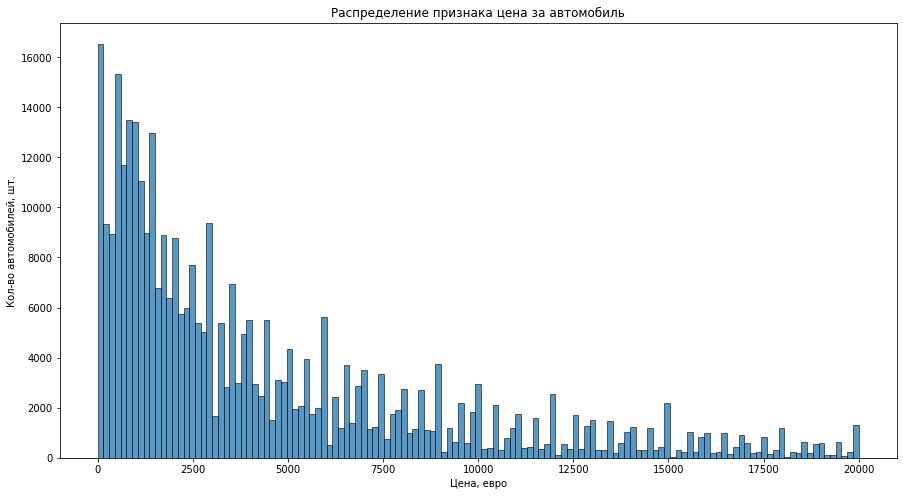

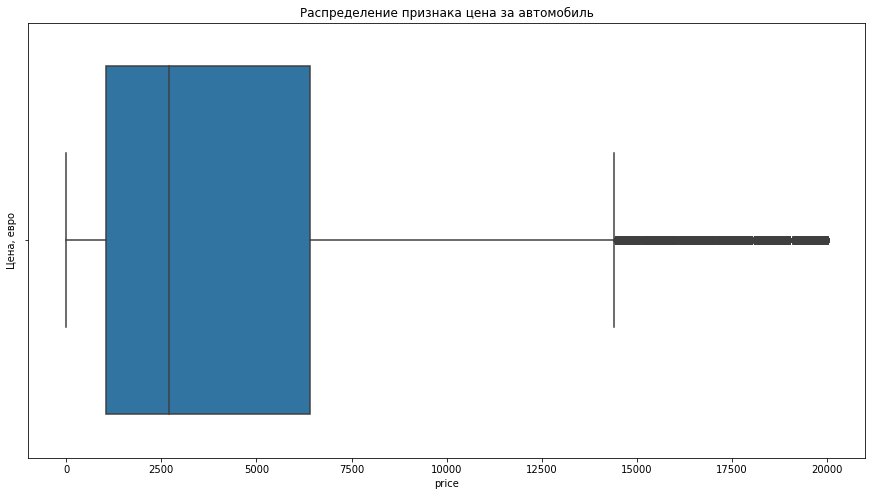

In [23]:
# Отобразим данные в столбце price
quant_feat(df_autos, 'price', 'Распределение признака цена за автомобиль', 'Цена, евро', 'Кол-во автомобилей, шт.')

Оценим кол-во автомобилей, с ценой равной 0 евро.

In [24]:
len(df_autos.query('price == 0')) / len(df_autos['price']) * 100

3.0398035923412303

Судя по полученным результатам, можно предположить, что цена равная 0 - это ошибочно внесенные данные.

Аномально низких значений цены 3.03% от общего кол-ва - достаточно мало.

Следовательно, ими можно пренебречь.

Для дальнейшего исследования, оставим автомобили с ценой выше 0.

In [25]:
df_autos = df_autos.query('price > 0')

**Изучим столбец `vehicle_type`**

count     309843
unique         8
top        sedan
freq       89405
Name: vehicle_type, dtype: object

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


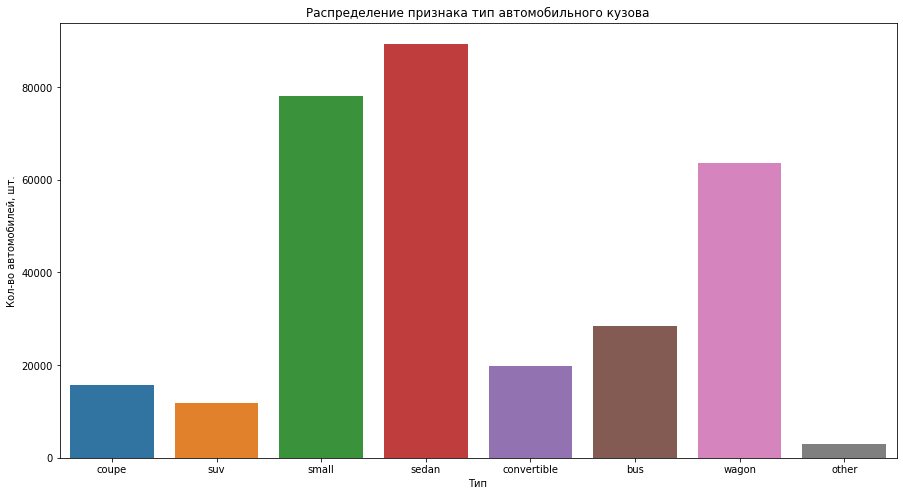

In [26]:
# Отобразим данные в столбце vehicle_type
qual_feat_count(df_autos, 'vehicle_type', 'Распределение признака тип автомобильного кузова', 'Тип', 'Кол-во автомобилей, шт.')

**Изучим столбец `registration_year`**

In [27]:
# Отобразим данные в столбце registration_year
df_autos['registration_year'].describe()

count    343593.00000
mean       2004.08983
std          78.41368
min        1000.00000
25%        1999.00000
50%        2003.00000
75%        2008.00000
max        9999.00000
Name: registration_year, dtype: float64

Оценим кол-во автомобилей, с годом регистрации позднее 2025 года

In [28]:
len(df_autos.query('registration_year > 2025')) / len(df_autos['registration_year']) * 100

0.02502961352530465

Оценим кол-во автомобилей, с годом регистрации ранее 1950 года

In [29]:
len(df_autos.query('registration_year < 1950')) / len(df_autos['registration_year']) * 100

0.052096521174761996

Судя по полученным результатам, можно предположить, что год регистрации позднее 2025 и раньше 1950 - это ошибочно внесенные данные.

Аномальных значений даты регистрации достаточно мало - в сумме менее 0,1% от общего кол-ва.

Следовательно, ими можно пренебречь.

Для дальнейшего исследования, оставим автомобили датой регистрации позднее 1950 и ранее 2025 годов включительно.

In [30]:
df_autos = df_autos.query('registration_year <= 2025 and registration_year >= 1950')

count    343328.000000
mean       2003.207816
std           7.213829
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


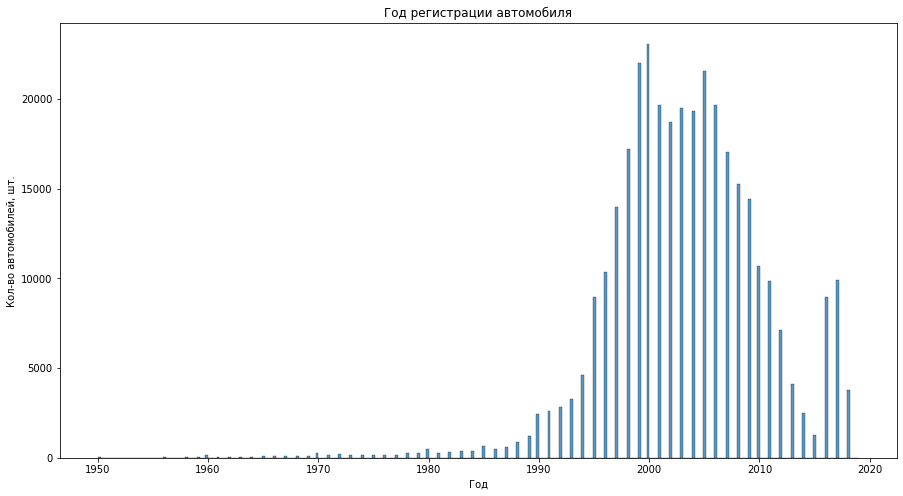

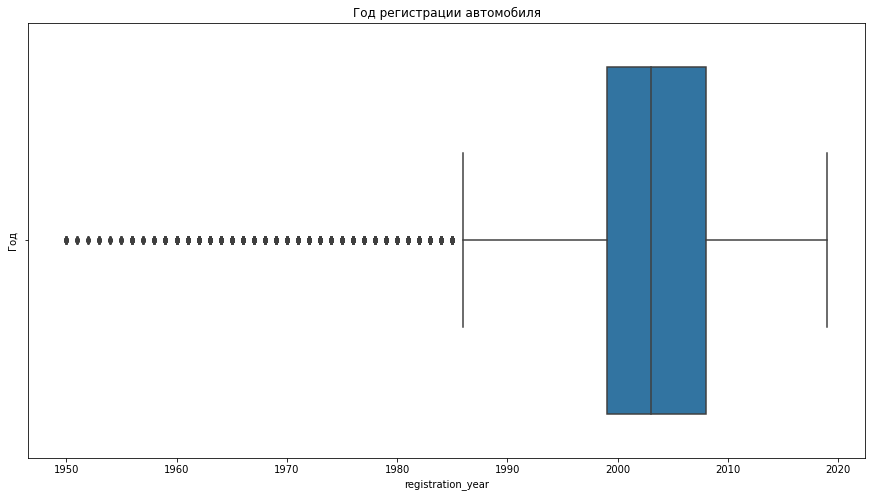

In [31]:
# Отобразим данные в столбце registration_year
quant_feat(df_autos, 'registration_year', 'Год регистрации автомобиля', 'Год', 'Кол-во автомобилей, шт.')

**Изучим столбец `gearbox`**

manual    261283
auto       64859
Name: gearbox, dtype: int64

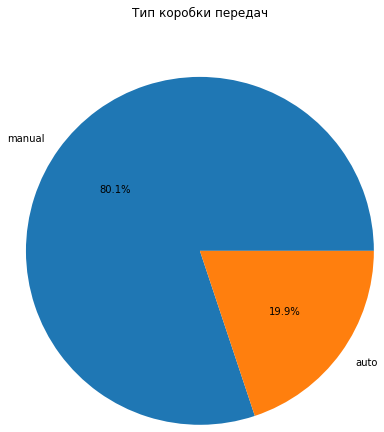

In [32]:
# Построим круговую диаграмму для стоблца gearbox
qual_feat_pie(df_autos, 'gearbox', 'Тип коробки передач', ['manual', 'auto'])

**Изучим столбец `power`**

count    343328.000000
mean        111.009935
std         187.873912
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


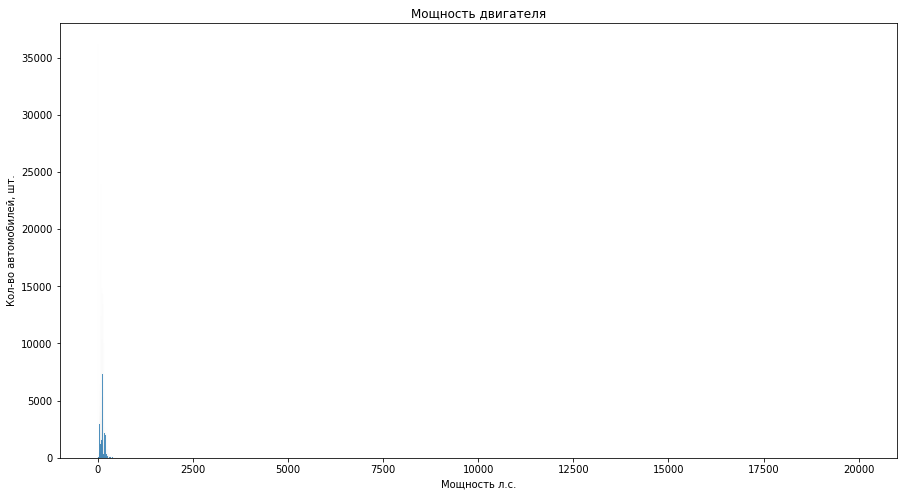

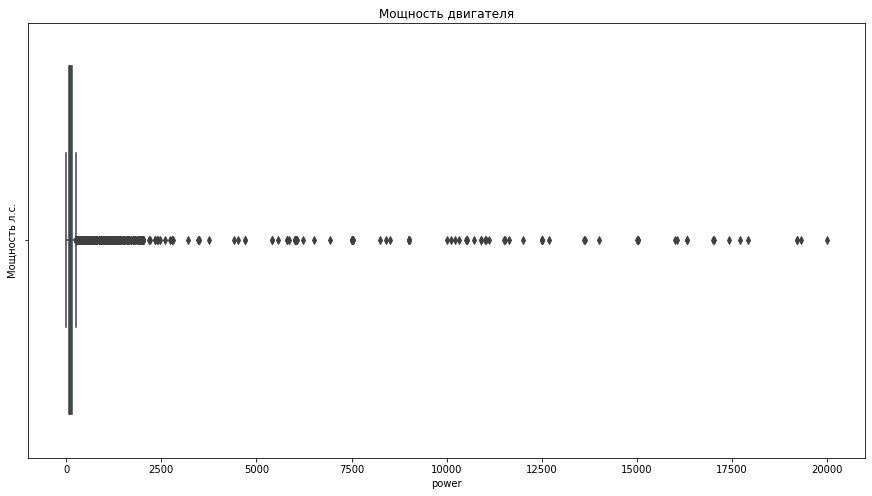

In [33]:
# Отобразим данные в столбце power
quant_feat(df_autos, 'power', 'Мощность двигателя', 'Мощность л.с.', 'Кол-во автомобилей, шт.')

Оценим кол-во автомобилей, с двигателем мощностью больше 2 500 л.с.

In [34]:
len(df_autos.query('power > 2500')) / len(df_autos['power']) * 100

0.02679653276167397

Судя по полученным результатам, можно предположить, что мощность двигателя более 2 500 л.с. - это ошибочно внесенные данные.

Традиционно, мощность двигателя для автомобиля не превышает 2 500 л.с.

Аномально высоких значений мощности 0,02% от общего кол-ва - достаточно мало.

Следовательно, ими можно пренебречь.

Для дальнейшего исследования, оставим автомобили с мощностью двигателя до 2 500 л.с.

In [35]:
df_autos = df_autos.query('power <= 2500')

Оценим кол-во автомобилей, с двигателем мощностью равно 0 л.с.

In [36]:
len(df_autos.query('power == 0')) / len(df_autos['power']) * 100

10.540852358144251

Судя по полученным результатам, можно предположить, что мощность двигателя равная 0 - это либо ошибка, либо знак того, что машина продается на металалом, т к она не на ходу.

count    343236.000000
mean        108.446279
std          72.246014
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max        2461.000000
Name: power, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


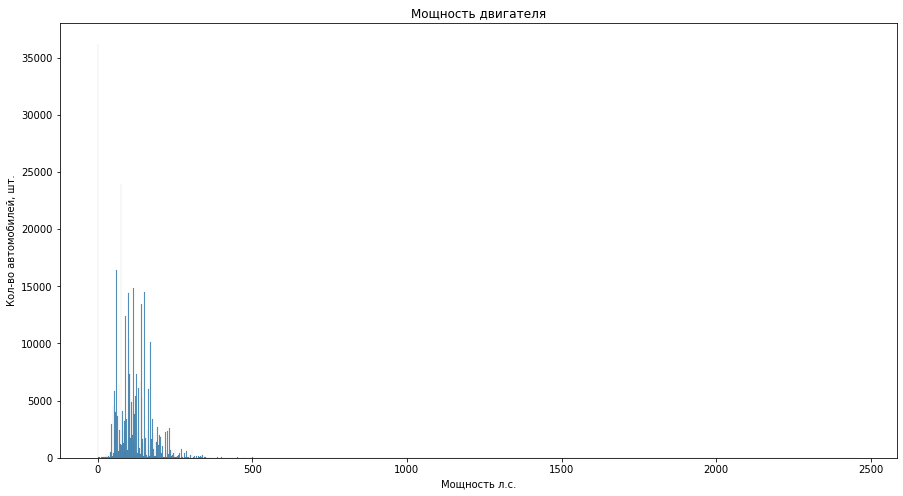

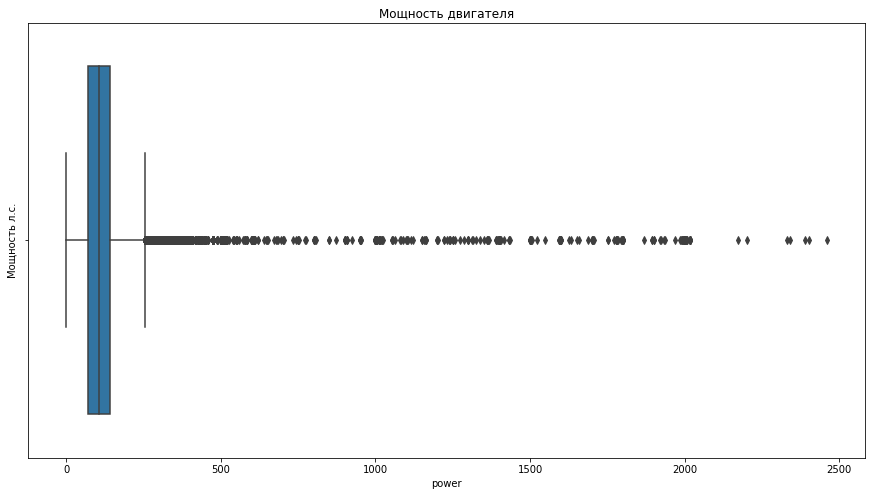

In [37]:
# Отобразим данные в столбце power
quant_feat(df_autos, 'power', 'Мощность двигателя', 'Мощность л.с.', 'Кол-во автомобилей, шт.')

**Изучим столбец `model`**

count     325831
unique       250
top         golf
freq       28225
Name: model, dtype: object

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


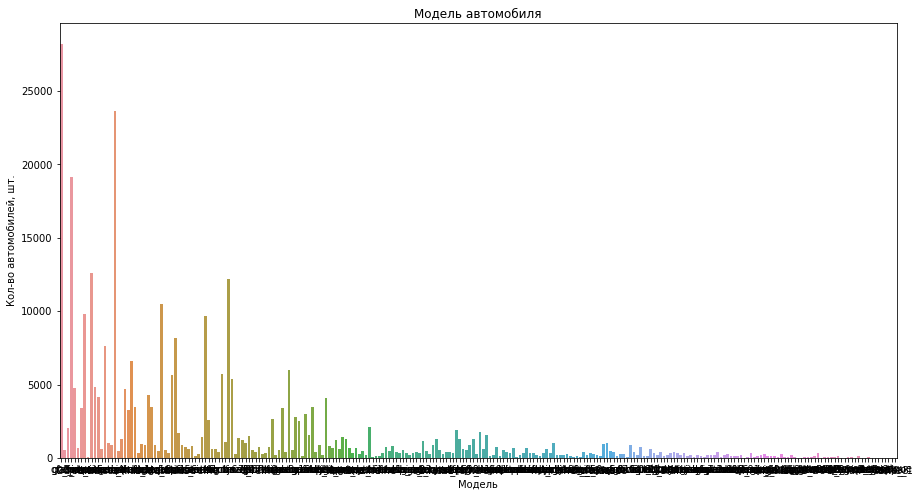

In [38]:
# Отобразим данные в столбце model
qual_feat_count(df_autos, 'model', 'Модель автомобиля', 'Модель', 'Кол-во автомобилей, шт.')

**Изучим столбец `kilometer`**

count    343236.000000
mean     128413.729912
std       37411.134827
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


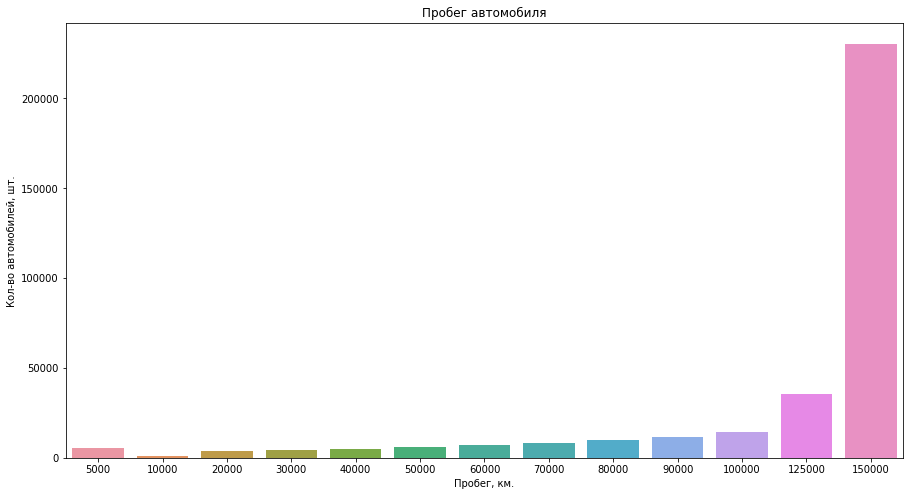

In [40]:
# Отобразим данные в столбце kilometer
qual_feat_count(df_autos, 'kilometer', 'Пробег автомобиля', 'Пробег, км.', 'Кол-во автомобилей, шт.')

**Изучим столбец `registration_month`**

count    343236.000000
mean          5.781086
std           3.696889
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


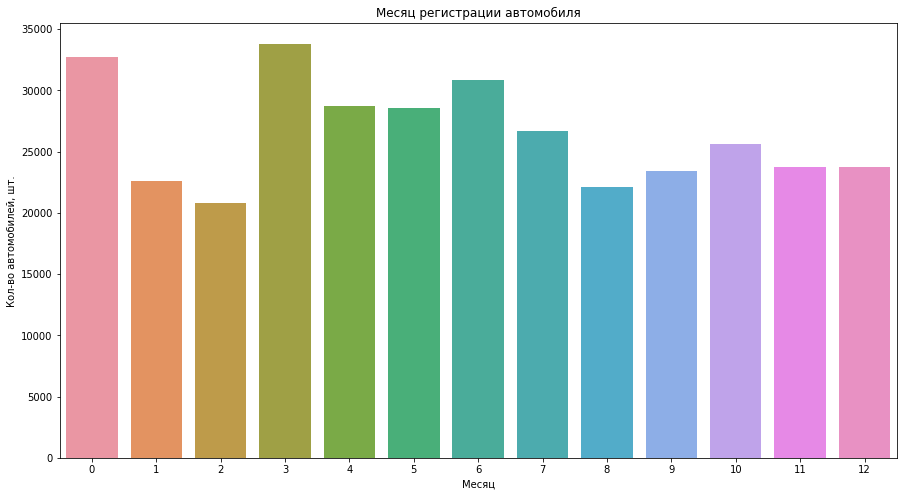

In [41]:
# Отобразим данные в столбце registration_month
qual_feat_count(df_autos, 'registration_month', 'Месяц регистрации автомобиля', 'Месяц', 'Кол-во автомобилей, шт.')

**Изучим столбец `fuel_type`**

count     313952
unique         7
top       petrol
freq      210612
Name: fuel_type, dtype: object

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


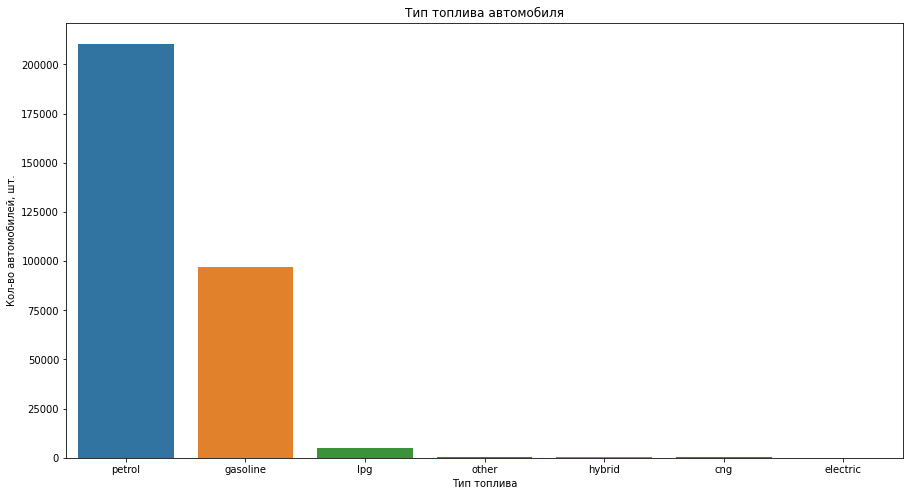

In [42]:
# Отобразим данные в столбце fuel_type
qual_feat_count(df_autos, 'fuel_type', 'Тип топлива автомобиля', 'Тип топлива', 'Кол-во автомобилей, шт.')

**Изучим столбец `brand`**

count         343236
unique            40
top       volkswagen
freq           74339
Name: brand, dtype: object

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


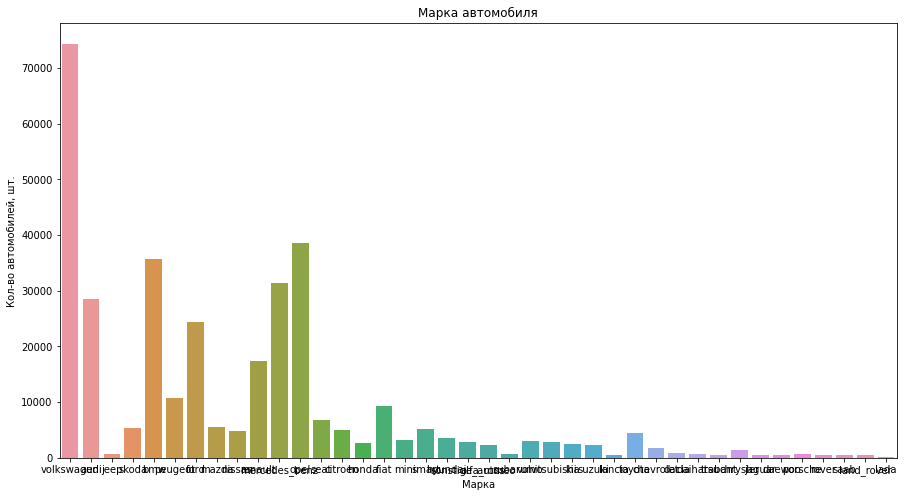

In [43]:
# Отобразим данные в столбце fuel_type
qual_feat_count(df_autos, 'brand', 'Марка автомобиля', 'Марка', 'Кол-во автомобилей, шт.')

**Изучим столбец `repaired`**

no     243588
yes     34011
Name: repaired, dtype: int64

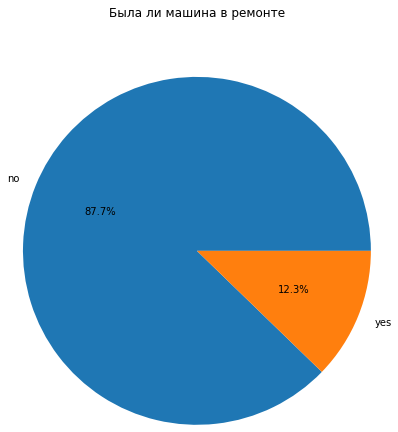

In [44]:
# Построим круговую диаграмму для стоблца repaired
qual_feat_pie(df_autos, 'repaired', 'Была ли машина в ремонте', ['no', 'yes'])

**Изучим столбец `date_created`**

In [45]:
df_autos['date_created'].min()

'2014-03-10 00:00:00'

In [46]:
df_autos['date_created'].max()

'2016-04-07 00:00:00'

**Изучим столбец `number_of_pictures`**

0    343236
Name: number_of_pictures, dtype: int64

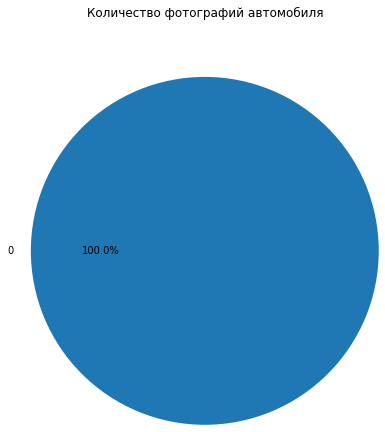

In [47]:
# Построим круговую диаграмму для стоблца number_of_pictures
qual_feat_pie(df_autos, 'number_of_pictures', 'Количество фотографий автомобиля', ['0'])

**Изучим столбец `postal_code`**

count    343236.000000
mean      50687.577218
std       25743.756568
min        1067.000000
25%       30449.000000
50%       49525.000000
75%       71229.000000
max       99998.000000
Name: postal_code, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


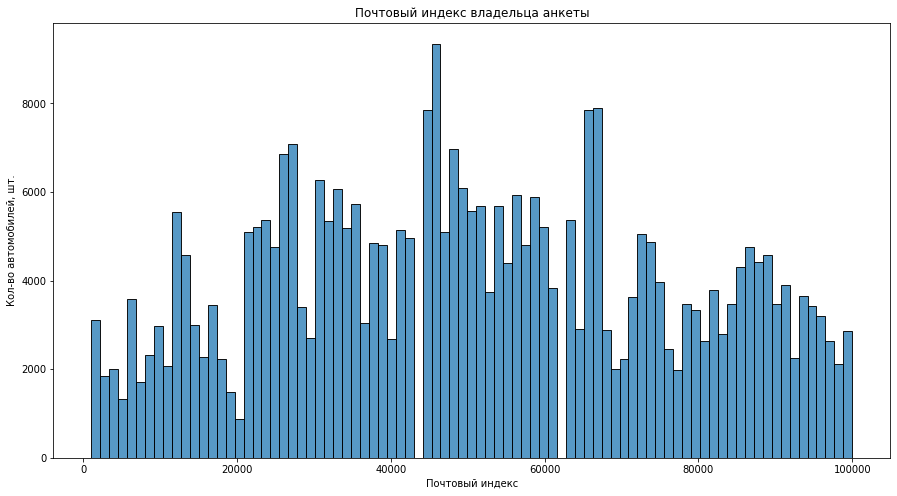

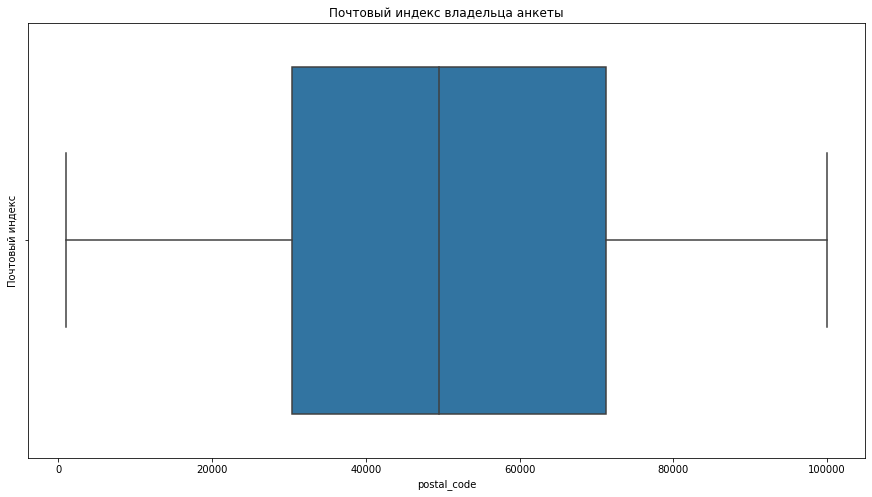

In [48]:
# Отобразим данные в столбце power
quant_feat(df_autos, 'postal_code', 'Почтовый индекс владельца анкеты', 'Почтовый индекс', 'Кол-во автомобилей, шт.')

**Изучим столбец `last_seen`**

In [49]:
df_autos['last_seen'].min()

'2016-03-05 14:15:08'

In [50]:
df_autos['last_seen'].max()

'2016-04-07 14:58:51'

На этапе исследовательского анализа данных, нам удалось:
1. Изучили и описали данные из таблицы df_autos

По полученым данным, можно сказать:
- средняя цена за автомобиль 4 400 евро
- средняя мощность двигателя автомобиля 110 л.с.
- 99% автомобилей зарегистрированы с 1985 по 2019 годы
- у большинства автомобилей пробег более 150 тыс. км
- у 80% автомобилей ручная коробка передач

##  Корреляционный анализ

**Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками**

In [51]:
# Создадим новую таблицу на базе старой, без данных о дате регистрации
df_autos_actual = df_autos.copy()
df_autos_actual = df_autos_actual.drop(columns=['date_crawled', 'date_created', 'last_seen'])

In [52]:
df_autos_actual.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,number_of_pictures,postal_code
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,0,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,0,67112
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,0,94505
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,0,27472
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,0,96224


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable number_of_pictures for analysis 1. Dropping this column
  warnings.warn(


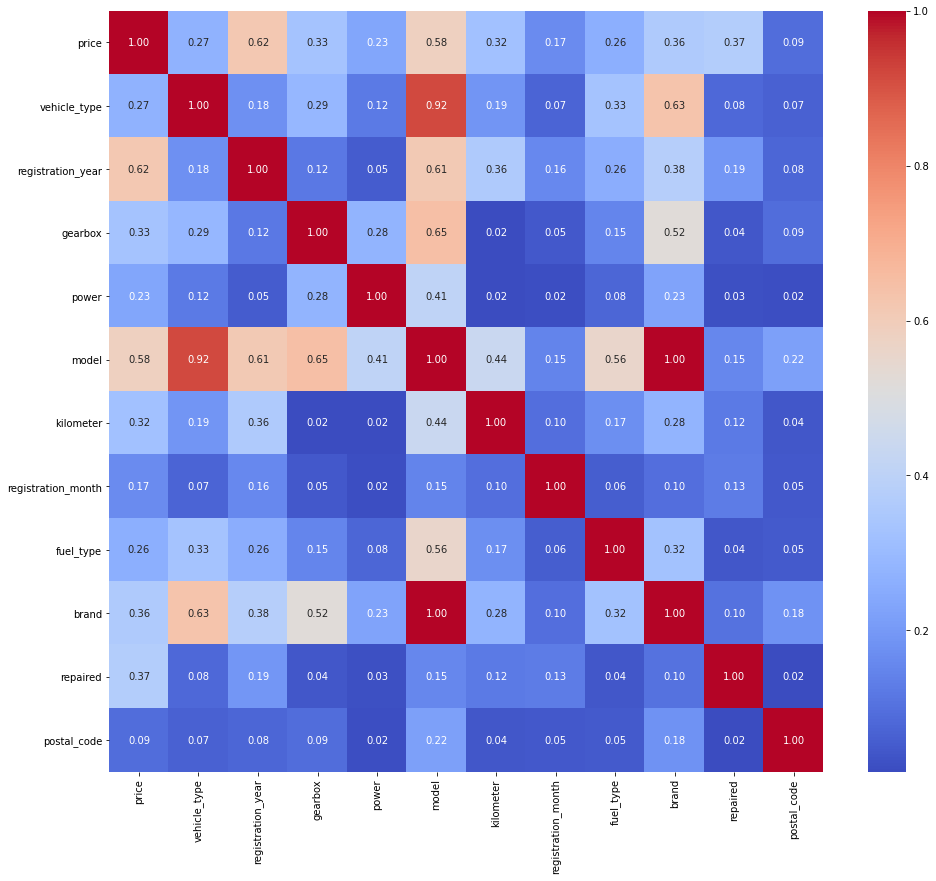

In [53]:
# Матрица корреляций для df_autos_actual
plt.figure(figsize=(16, 14))
sns.heatmap(df_autos_actual.phik_matrix(interval_cols = ['price', 'power', 'postal_code', 'registration_year', 'registration_month', 'number_of_pictures']), annot=True,  cmap='coolwarm', fmt='.2f');

Судя по тепловой карте и опираясь на шкалу Чеддока мы можем сказать, что:
- Есть заметная связь с целевым признаком `price` у входного признака `registration_year` и `model`
- Есть умеренная связь с целевым признаком `price` у входного признака `gearbox`, `kilometr`, `brand`, `repaired`
- Среди входных признаков `vehicle_type` и `model` замечана мультиколлинеарность - коэффициент корреляции равен 0.92 по модулю
- Среди входных признаков `model` и `brand` замечана мультиколлинеарность - коэффициент корреляции равен 1 по модулю

Проблемук мультиколлинеарности устраним с помощью регуляризации на следующем этапе.

На этапе корреляционного анализа данных, нам удалось:
1. Рассчитать и изучить взаимосвязи между всеми признаками


2. Определить тип взаимосвязи между целевыми и входными признаками


3. Проверить входные данные на мультиколлинеарность

## Обучение моделей

### Подготовим данные

In [55]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [56]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    df_autos_actual.drop('price', axis=1),
    df_autos_actual['price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [57]:
# Вывод необходимых размерностей
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(257427, 12)
(257427,)
(85809, 12)
(85809,)


In [58]:
df_autos_actual.head(10)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,number_of_pictures,postal_code
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,0,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,0,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,0,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,0,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,0,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,0,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,0,67112
8,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,0,94505
9,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,0,27472
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,0,96224


In [61]:
# Создаём списки с названиями признаков
te_columns = ['vehicle_type' , 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_columns = ['registration_year', 'power', 'kilometer', 'registration_month', 'number_of_pictures', 'postal_code']

In [62]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + te
te_pipe = Pipeline(
    [('simpleImputer_te', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('te', TargetEncoder(target_type='continuous'))
    ]
    )

In [63]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('te', te_pipe, te_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [64]:
# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor())
])

### Обучим четыре модели

In [65]:
# В списке словарей укажем, какие модели и какие варианты масштабирования собираемся перебрать
param_grid = [
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor()],
        'models__n_estimators': range(10, 100),
        'models__max_depth': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'models__C': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели RandomForestRegressor()
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    },
    
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [66]:
# Создаём функцию для оценки качества модели
def root_mean_squared_error(y_true, y_pred):
    diff = y_pred - y_true # находим разницу между прогнозируемыми и наблюдаемыми значениями 
    differences_squared = diff ** 2 # возводим в квадрат
    mean_diff = differences_squared.mean() # находим среднее значение
    rmse_val = np.sqrt(mean_diff) # извлекаем квадратный корень
    return rmse_val

In [67]:
# Создаём пользовательскую метрику
scorer_rmse = make_scorer(root_mean_squared_error, greater_is_better=False)

In [68]:
# Переберём разные модели и варианты масштабирования
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=scorer_rmse,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4557.207351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4549.948077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4557.101533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4559.423173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4554.382423


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4557.207351


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4549.948077


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4557.101533


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4559.423173


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4554.382423


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4557.207351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4549.948077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4557.101533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4559.423173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4554.382423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4557.207351


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4549.948077


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4557.101533


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4559.423173


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4554.382423


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4557.207351


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4549.948077


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4557.101533


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4559.423173


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4554.382423


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4557.207351


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4549.948077


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4557.101533


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4559.423173


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4554.382423


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4557.207351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4549.948077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4557.101533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4559.423173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1160
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4554.382423
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4557.207351


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205941, number of used features: 11
[LightGBM] [Info] Start training from score 4549.948077


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4557.101533


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4559.423173


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1162
[LightGBM] [Info] Number of data points in the train set: 205942, number of used features: 11
[LightGBM] [Info] Start training from score 4554.382423


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1164
[LightGBM] [Info] Number of data points in the train set: 257427, number of used features: 11
[LightGBM] [Info] Start training from score 4555.612515


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('te',
                                                                               Pipeline(steps=[('simpleImputer_te',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('te',
                                                                                                TargetEncoder(target_type='continuous'))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'brand',
                                                                                'repaired']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               ['regis...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 15),
                                         'models__max_features': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

### Выберем лучшую модель

In [69]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', -randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('te',
                                                  Pipeline(steps=[('simpleImputer_te',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('te',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired']),
                                                 ('num', StandardScaler(),
                                                  ['registration_year', 'power',
                                                   'kilome

Для предсказания цены на автомобиль, мы:
- собрали пайплайн
- обучили и сделали прогноз по 4-ем моделям

Наилучший результат показала модель:
- LGBMRegressor с параметрами max_depth=12, n_estimators=83

## Анализ моделей

### Оценим модели

In [70]:
# Сохраним 10 лучших результатов в датафрейм и выведим на экран
all_results = pd.DataFrame(randomized_search.cv_results_)
all_results = all_results.sort_values(by='rank_test_score')
all_results = all_results.reset_index(drop=True)
all_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_estimators,param_models__max_depth,param_models,param_models__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.959976,0.026998,0.352698,0.012539,StandardScaler(),83.0,12,LGBMRegressor(),NaN,"{'preprocessor__num': StandardScaler(), 'model...",-1746.949811,-1771.240955,-1755.411914,-1759.330827,-1743.698566,-1755.326414,9.743609,1
1,1.936229,0.025324,0.336969,0.007199,StandardScaler(),77.0,13,LGBMRegressor(),NaN,"{'preprocessor__num': StandardScaler(), 'model...",-1755.114569,-1773.941904,-1761.046147,-1765.022232,-1755.107766,-1762.046524,7.036391,2
2,1.960359,0.024691,0.358082,0.010430,StandardScaler(),78.0,14,LGBMRegressor(),NaN,"{'preprocessor__num': StandardScaler(), 'model...",-1761.751818,-1775.693215,-1764.280577,-1770.701280,-1752.538220,-1764.993022,7.914713,3
3,1.620548,0.022421,0.252577,0.007408,passthrough,50.0,13,LGBMRegressor(),NaN,"{'preprocessor__num': 'passthrough', 'models__...",-1796.228951,-1819.219756,-1814.641117,-1819.096915,-1803.037329,-1810.444814,9.235031,4
4,1.400980,0.023402,0.186137,0.009222,passthrough,31.0,8,LGBMRegressor(),NaN,"{'preprocessor__num': 'passthrough', 'models__...",-1892.592439,-1912.559214,-1910.797116,-1915.891341,-1892.074198,-1904.782861,10.297162,5
5,23.813118,0.439913,0.418907,0.016517,MinMaxScaler(),NaN,8,RandomForestRegressor(random_state=42),5.0,"{'preprocessor__num': MinMaxScaler(), 'models_...",-1951.226703,-1975.029193,-1969.325868,-1969.378940,-1953.602589,-1963.712659,9.484634,6
6,1.525592,0.021707,0.214342,0.009466,MinMaxScaler(),75.0,3,LGBMRegressor(),NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-1962.134444,-1980.905458,-1988.405384,-1990.183351,-1975.351645,-1979.396056,10.140341,7
7,1.254335,0.028882,0.143371,0.003166,passthrough,26.0,5,LGBMRegressor(),NaN,"{'preprocessor__num': 'passthrough', 'models__...",-1993.298547,-2019.457867,-2005.122092,-2014.980445,-1996.820183,-2005.935827,10.080760,8
8,1.283700,0.023199,0.161179,0.011800,MinMaxScaler(),53.0,2,LGBMRegressor(),NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2233.163743,-2244.997425,-2233.753079,-2215.014215,-2212.414161,-2227.868525,12.329941,9
9,0.813241,0.017592,0.096959,0.005393,MinMaxScaler(),NaN,12,DecisionTreeRegressor(random_state=42),2.0,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2366.915245,-2529.049742,-2392.512158,-2349.026777,-2433.873862,-2414.275557,64.080036,10


In [71]:
# Выберем лучшие варианты для 3-ех разных моделей
results = pd.DataFrame(randomized_search.cv_results_)
results['model_name'] = results['param_models'].apply(lambda x: x.__class__.__name__)
top_per_model = results.groupby('model_name').apply(lambda x: x.nlargest(1, 'mean_test_score'))
top_per_model

,,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_estimators,param_models__max_depth,param_models,param_models__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,model_name
model_name,,,,,,,,,,,,,,,,,,,,
DecisionTreeRegressor,4,0.813241,0.017592,0.096959,0.005393,MinMaxScaler(),NaN,12,DecisionTreeRegressor(random_state=42),2.0,"{'preprocessor__num': MinMaxScaler(), 'models_...",-2366.915245,-2529.049742,-2392.512158,-2349.026777,-2433.873862,-2414.275557,64.080036,10,DecisionTreeRegressor
LGBMRegressor,7,1.959976,0.026998,0.352698,0.012539,StandardScaler(),83.0,12,LGBMRegressor(),NaN,"{'preprocessor__num': StandardScaler(), 'model...",-1746.949811,-1771.240955,-1755.411914,-1759.330827,-1743.698566,-1755.326414,9.743609,1,LGBMRegressor
RandomForestRegressor,1,23.813118,0.439913,0.418907,0.016517,MinMaxScaler(),NaN,8,RandomForestRegressor(random_state=42),5.0,"{'preprocessor__num': MinMaxScaler(), 'models_...",-1951.226703,-1975.029193,-1969.325868,-1969.378940,-1953.602589,-1963.712659,9.484634,6,RandomForestRegressor


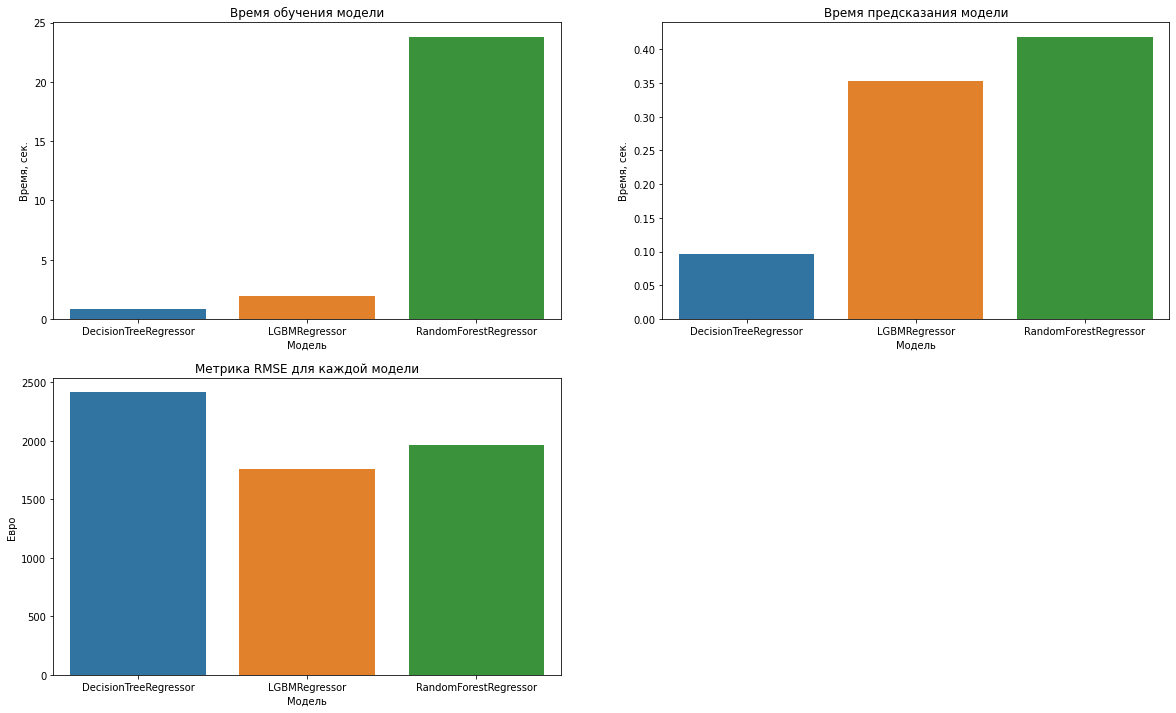

In [72]:
# Построим графики для 3-ех основных параметров для всех моделей и сравним их
top_per_model['mean_test_score'] = -top_per_model['mean_test_score']
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
sns.barplot(data=top_per_model, x='model_name', y='mean_fit_time', ax=axes[0][0]).set(title='Время обучения модели', xlabel='Модель', ylabel='Время, сек.')
sns.barplot(data=top_per_model, x='model_name', y='mean_score_time', ax=axes[0][1]).set(title='Время предсказания модели', xlabel='Модель', ylabel='Время, сек.')
sns.barplot(data=top_per_model, x='model_name', y='mean_test_score', ax=axes[1][0]).set(title='Метрика RMSE для каждой модели', xlabel='Модель', ylabel='Евро');
fig.delaxes(axes[1][1])

Рейтинг моделей:
1. LGBMRegressor

- Время обучения - 2.00 сек
- Время предсказания - 0.33 сек
- RMSE на кросс-валидации - 1756.95


2. RandomForestRegressor

- Время обучения - 23.20 сек
- Время предсказания - 0.38 сек
- RMSE на кросс-валидации - 1961.83


3. DecisionTreeRegressor

- Время обучения - 0.77 сек
- Время предсказания - 0.08 сек
- RMSE на кросс-валидации - 2477.61

Как видно из полученных результатов выше, самой оптимальной моделью с точи зрения времени и точности прогноза является модель LGBMRegressor.

Применим ее на тестовых данных.

### Проверим лучшую модель на тестовой выборке

In [73]:
# Проверим работу модели на тестовой выборке
# Рассчитаем прогноз на тестовых данных
y_test_pred_one = randomized_search.predict(X_test)  
print(f'Метрика RMSE на тестовой выборке: {root_mean_squared_error(y_test, y_test_pred_one)}')

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Метрика RMSE на тестовой выборке: 1758.6173000231652


### Определим важность различных признаков

In [74]:
# Посчитаем веса всех признаков для лучшей модели
randomized_search.best_estimator_._final_estimator.feature_importances_

array([177,  34, 338,  67, 321,  76, 615, 505, 224,  45,   0,  88],
      dtype=int32)

In [75]:
# Выведем порядок различных признаков
randomized_search.best_estimator_.feature_names_in_

array(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'number_of_pictures', 'postal_code'], dtype=object)

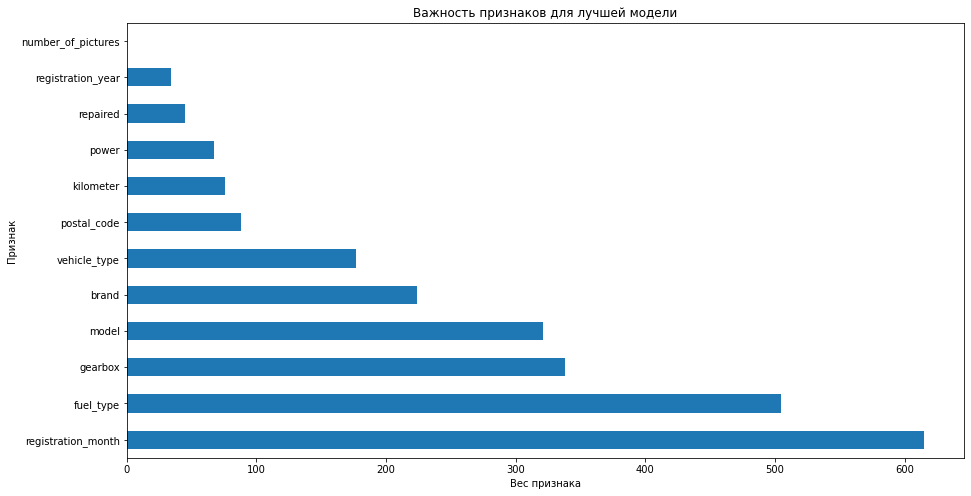

In [76]:
# Посроим график важности различных признаков
plt.figure(figsize=(15,8))
feat_importances = pd.Series(randomized_search.best_estimator_._final_estimator.feature_importances_, index=randomized_search.best_estimator_.feature_names_in_)
feat_importances.nlargest(12).plot(kind='barh')
plt.title('Важность признаков для лучшей модели')
plt.xlabel('Вес признака')
plt.ylabel('Признак');

## Общий вывод

**В процессе исследования, мы:**

1. Выгрузили исходные данные в 1 датафрейм

2. Предобработали данные - выставили корректные типы данных, избавились от дубликатов

3. Провели исследовательский анализ данных

По полученным данным, можно сделать несколько выводов:
- средняя цена за автомобиль 4 400 евро
- средняя мощность двигателя автомобиля 110 л.с.
- 99% автомобилей зарегистрированы с 1985 по 2019 годы
- у большинства автомобилей пробег более 150 тыс. км
- у 80% автомобилей ручная коробка передач

4. Провели корреляционный анализ данных

Судя по тепловой карте и опираясь на шкалу Чеддока мы можем сказать, что:
- Есть заметная связь с целевым признаком `price` у входного признака `registration_year` и `model`
- Есть умеренная связь с целевым признаком `price` у входного признака `gearbox`, `kilometr`, `brand`, `repaired`

5. Собрали пайплайн, обучили и сделали прогноз для 4-ех моделей

Наилучший результат показала модель:
- LGBMRegressor с параметрами max_depth=12, n_estimators=83

Рейтинг моделей:
1. LGBMRegressor

- Время обучения - 5.05 сек
- Время предсказания - 0.48 сек
- RMSE на кросс-валидации - 1867.55


2. RandomForestRegressor

- Время обучения - 5.31 сек
- Время предсказания - 0.31 сек
- RMSE на кросс-валидации - 3830.25


3. DecisionTreeRegressor

- Время обучения - 0.76 сек
- Время предсказания - 0.11 сек
- RMSE на кросс-валидации - 4308.54

6. Выбрали лучшую модель и проверили ее на тестовых данных

- Метрика RMSE на тестовой выборке: 1760.62